In [1]:
"""
Links:
1- https://github.com/opengeos/segment-geospatial/tree/main
2- https://github.com/ayushdabra/dubai-satellite-imagery-segmentation/tree/main
3- dataspace.copernicus.eu

Datasets:
100points_pixelIntensitiesB4.csv --> it contains red color pixel intensity values each 100 points for a year 
100points_pixelIntensitiesB3.csv --> it contains green color pixel intensity values each 100 points for a year 
100points_pixelIntensitiesB2.csv --> it contains blue color pixel intensity values each 100 points for a year 

The files which are in below contain different infrared pixel intensity values each 100 points for a year
100points_pixelIntensitiesB9.csv, 100points_pixelIntensitiesB10.csv, 100points_pixelIntensitiesB10.csv 

10k_random.csv --> it contains coordinates of random 100 points in baltic region
100points_iou.csv --> it contains iou values of each 100 points for a year which were gotten using SAMGeo segmentation model
100points_scores.csv --> it contains score values of each 100 points for a year which were gotten using SAMGeo segmentation model (predict function)

100points_probabilities.json --> it contains segmentation class probabilities of center pixel of each image. 2nd github link was used for that
VAR_results.json --> it contains VAR Model result for each 100 points. Structure of the json is in below.
                     [
                        {
                            'rmse_results': {
                                'rmse_b4': rmse_result[0], 'rmse_b3': rmse_result[1], 'rmse_b2': rmse_result[2],
                                'rmse_iou': rmse_result[3], 'rmse_score': rmse_result[4],
                                'rmse_class1': rmse_result[5], 'rmse_class2': rmse_result[6], 'rmse_class3': rmse_result[7],
                                'rmse_class4': rmse_result[8], 'rmse_class5': rmse_result[9], 'rmse_class6': rmse_result[10]
                            },
                            'aic': aic,
                            'confidence_intervals': {
                                'conf_mid_b4': conf_mid_b4.tolist(), 'conf_lower_b4': conf_lower_b4.tolist(), 'conf_upper_b4': conf_upper_b4.tolist(),
                                'conf_mid_b3': conf_mid_b3.tolist(), 'conf_lower_b3': conf_lower_b3.tolist(), 'conf_upper_b3': conf_upper_b3.tolist(),
                                'conf_mid_b2': conf_mid_b2.tolist(), 'conf_lower_b2': conf_lower_b2.tolist(), 'conf_upper_b2': conf_upper_b2.tolist(),
                                'conf_mid_iou': conf_mid_iou.tolist(), 'conf_lower_iou': conf_lower_iou.tolist(), 'conf_upper_iou': conf_upper_iou.tolist(),
                                'conf_mid_score': conf_mid_score.tolist(), 'conf_lower_score': conf_lower_score.tolist(), 'conf_upper_score': conf_upper_score.tolist(),
                                'conf_mid_class1': conf_mid_class1.tolist(), 'conf_lower_class1': conf_lower_class1.tolist(), 'conf_upper_class1': conf_upper_class1.tolist(),
                                'conf_mid_class2': conf_mid_class2.tolist(), 'conf_lower_class2': conf_lower_class2.tolist(), 'conf_upper_class2': conf_upper_class2.tolist(),
                                'conf_mid_class3': conf_mid_class3.tolist(), 'conf_lower_class3': conf_lower_class3.tolist(), 'conf_upper_class3': conf_upper_class3.tolist(),
                                'conf_mid_class4': conf_mid_class4.tolist(), 'conf_lower_class4': conf_lower_class4.tolist(), 'conf_upper_class4': conf_upper_class4.tolist(),
                                'conf_mid_class5': conf_mid_class5.tolist(), 'conf_lower_class5': conf_lower_class5.tolist(), 'conf_upper_class5': conf_upper_class5.tolist(),
                                'conf_mid_class6': conf_mid_class6.tolist(), 'conf_lower_class6': conf_lower_class6.tolist(), 'conf_upper_class6': conf_upper_class6.tolist()
                            }
                        }
                    ]
"""
"""
1- create fall in confidence interval column 1 --> prediction is in CI, 0 --> not
2- If CI is 0, calculate the error and save image
"""
import numpy as np
import pandas as pd
import json
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse

/tmp/ipykernel_32168/1811281987.py:51: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Read Data

In [96]:
index = 21 

# Read Json
points_probabilities = 'data/100points_probabilities.json'
cloud_json = 'data/cloud_probabilities.json'
cloud_prob = []
cloud_date = []

with open(points_probabilities, 'r') as file:
    json_data_probabilities = json.load(file)

with open(cloud_json, 'r') as file:
    json_cloud = json.load(file)

# Get class class probabilities
class1_data = [entry['classes']['class1'] for entry in json_data_probabilities[str(index)]]
class2_data = [entry['classes']['class2'] for entry in json_data_probabilities[str(index)]]
class3_data = [entry['classes']['class3'] for entry in json_data_probabilities[str(index)]]
class4_data = [entry['classes']['class4'] for entry in json_data_probabilities[str(index)]]
class5_data = [entry['classes']['class5'] for entry in json_data_probabilities[str(index)]]
class6_data = [entry['classes']['class6'] for entry in json_data_probabilities[str(index)]]

for key, value in json_cloud[str(index)].items():
    if key == 'probabilities':
        for date, prob in value.items():
            cloud_date.append(date)
            cloud_prob.append(prob)

# Read csv
pixel_df4 = pd.read_csv('data/100points_pixelIntensitiesB4.csv')
pixel_df3 = pd.read_csv('data/100points_pixelIntensitiesB3.csv')
pixel_df2 = pd.read_csv('data/100points_pixelIntensitiesB2.csv')
iou_df = pd.read_csv('data/100points_iou.csv')
scores_df = pd.read_csv('data/100points_scores.csv')

date_series = pd.to_datetime(cloud_date) 
date = pd.DataFrame(date_series, columns=['Date'])

In [97]:
"""
This cell prepares "concat" dataframe for VAR Model.
Columns --> ['Pixel_Intensity_B4', 'Pixel_Intensity_B3', 'Pixel_Intensity_B2', 
            'IOU', 'Scores', 'Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6']
"""

pixel_b4 = pixel_df4[[str(index)]]
pixel_b3 = pixel_df3[[str(index)]]
pixel_b2 = pixel_df2[[str(index)]]
iou = iou_df[[str(index)]]
scores = scores_df[[str(index)]]
class1_df = pd.DataFrame(class1_data)
class2_df = pd.DataFrame(class2_data)
class3_df = pd.DataFrame(class3_data)
class4_df = pd.DataFrame(class4_data)
class5_df = pd.DataFrame(class5_data)
class6_df = pd.DataFrame(class6_data)
cloud_df = pd.DataFrame(cloud_prob, columns=['Cloud'])

concat = pd.concat([pixel_b4, pixel_b3, pixel_b2, iou, scores,
                    class1_df, class2_df, class3_df, class4_df, class5_df, class6_df, cloud_df], axis=1)

concat.columns = ['Pixel_Intensity_B4', 'Pixel_Intensity_B3', 'Pixel_Intensity_B2', 
                  'IOU', 'Scores', 'Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Cloud_Prob']

# concat['Mean_rgb'] = concat[['Pixel_Intensity_B4', 'Pixel_Intensity_B3', 'Pixel_Intensity_B2']].mean(axis=1)
concat = concat.dropna()

In [98]:
concat

,Pixel_Intensity_B4,Pixel_Intensity_B3,Pixel_Intensity_B2,IOU,Scores,Class1,Class2,Class3,Class4,Class5,Class6,Cloud_Prob
0,7646.0,6409.0,7513.0,1.011129,0.991645,0.036006,0.917259,0.013245,0.004175,0.006950,0.022366,100.0
1,3187.0,2925.0,3783.0,1.038735,0.982492,0.141831,0.816591,0.012211,0.001383,0.004909,0.023076,100.0
2,5634.0,4905.0,5899.0,1.027471,0.984593,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,99.0
3,4403.0,4105.0,5227.0,1.038958,0.982503,0.138844,0.819772,0.012197,0.001383,0.004896,0.022908,39.0
4,747.0,1037.0,1637.0,1.027471,0.984593,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...
122,6897.0,6166.0,6794.0,1.030074,0.982609,0.142708,0.815626,0.012217,0.001385,0.004916,0.023148,79.0
123,7626.0,7058.0,7664.0,1.027471,0.984593,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,98.0
124,1649.0,1831.0,2258.0,1.038243,0.982671,0.144404,0.813875,0.012213,0.001381,0.004918,0.023209,97.0
125,6302.0,5716.0,6509.0,1.027471,0.984593,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,97.0


Visualization of Class Parameters

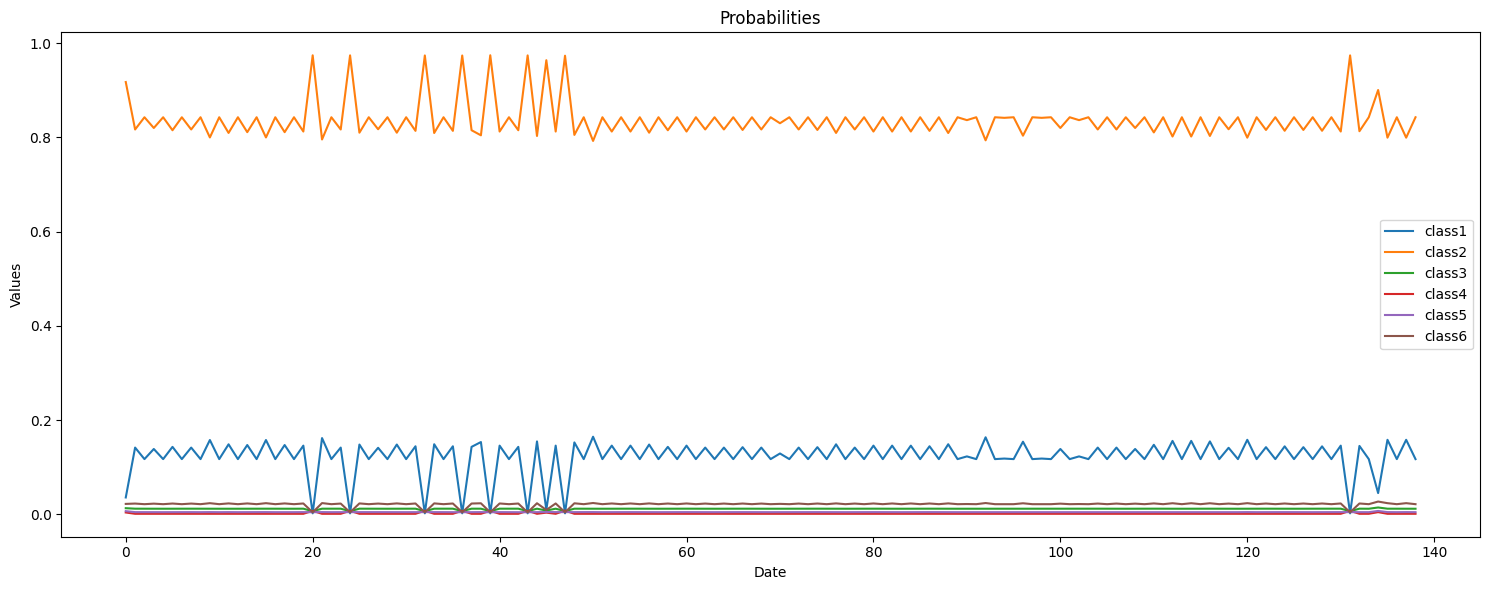

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

plt.plot(class1_df, label='class1')
plt.plot(class2_df, label='class2')
plt.plot(class3_df, label='class3')
plt.plot(class4_df, label='class4')
plt.plot(class5_df, label='class5')
plt.plot(class6_df, label='class6')
plt.title('Probabilities')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

VAR Model

In [100]:
"""
forecast_ci returns 3 confidence values for each forecasting dates.
forecast_ci[:, :, :] --> (confidence_values, rows, columns), in this case the shape is usually (3, rows, 11)
forecast_ci[0:1, :, :] --> returns medium confidence values for all rows and columns
forecast_ci[1:2, :, :] --> returns the lowest confidence values for all rows and columns
forecast_ci[2:, :, :] --> --> returns the highest confidence values for all rows and columns
"""
import scipy.stats as st
import math

noise_factor = 0.005
means = []
try:
    model = VAR(concat)
    model_fitted = model.fit()

    lag_order = model_fitted.k_ar

    forecast = model_fitted.forecast(concat.values[-lag_order:], steps=12) # forecasting for 12 days                       

    for column in concat.columns:
        means.append(np.mean(concat[column]))

    low_conf, high_conf = st.t.interval(confidence=0.999, df=len(concat)-1, 
                                        loc=means, 
                                        scale=st.sem(concat)) 
    
    # forecast_ci = model_fitted.forecast_interval(concat.values[-lag_order:], steps=12, alpha=0.5)
    # forecast_ci = np.array(forecast_ci)

    # Root Mean Squared Error 
    rmse_result = rmse(concat.values[-lag_order:], forecast) 

    # Akaike Information Criteria
    try:
        aic = model_fitted.aic
    except np.linalg.LinAlgError: # If a value is negative, aic function returns LinAlgError
        aic = None

except ValueError: 
    '''
    If a column is constant, VAR model doesn't work. 
    To prevent this situation small amount of noise is added to columns
    '''
    for column in concat.columns:
        noise = np.random.normal(0, noise_factor, concat.shape[0])
        concat[column] = concat[column] + noise
        
    model = VAR(concat)
    model_fitted = model.fit()

    lag_order = model_fitted.k_ar
    forecast = model_fitted.forecast(concat.values[-lag_order:], steps=12) # forecasting for 12 days

    for column in concat.columns:
        means.append(np.mean(concat[column]))

    low_conf, high_conf = st.t.interval(confidence=0.999, df=len(concat)-1, 
                                        loc=means, 
                                        scale=st.sem(concat)) 

    # forecast_ci = model_fitted.forecast_interval(concat.values[-lag_order:], steps=12, alpha=0.5)
    # forecast_ci = np.array(forecast_ci)

    # Root Mean Squared Error 
    rmse_result = rmse(concat.values[-lag_order:], forecast) 

    # Akaike Information Criteria 
    try:
        aic = model_fitted.aic
    except np.linalg.LinAlgError: # If a value is negative, aic function returns LinAlgError
        aic = None


print(f"Root Mean Squared Error: {rmse_result}")
print(f"Akaike Information Criteria AIC: {aic}")

Root Mean Squared Error: [6.59237267e+02 6.76576719e+02 6.40744376e+02 2.94816333e-03
 2.23357061e-03 2.33127709e-02 2.54261295e-02 4.44810511e-04
 4.45920792e-04 6.27404750e-05 2.05250138e-03 3.44291277e+01]
Akaike Information Criteria AIC: -98.54668150947376


Full Dataframe for the selected index

In [101]:
"""
Concat and forecast dataframes are merged.
Date, Fitted and Index columns are added.
Fitted 0 --> It means that, it's row used in VAR Model
Fitted 1 --> It means that, it's row is forecasting data
"""
forecast_df_ = pd.DataFrame(forecast, columns=concat.columns)
forecast_df_['Fitted'] = 1
datetime_series = pd.to_datetime(date['Date'])  
begining_date = datetime_series.max()

for i in range(len(forecast_df_)):
    begining_date += pd.Timedelta(days=1)
    forecast_df_.at[i, 'Date'] = begining_date.date()

full_df = concat.copy()
full_df['Date'] = date 
full_df['Fitted'] = 0
full_df = pd.concat([full_df, forecast_df_], axis=0)

full_df['Index'] = range(1, len(full_df) + 1)
full_df

,Pixel_Intensity_B4,Pixel_Intensity_B3,Pixel_Intensity_B2,IOU,Scores,Class1,Class2,Class3,Class4,Class5,Class6,Cloud_Prob,Date,Fitted,Index
0,7646.000000,6409.000000,7513.000000,1.011129,0.991645,0.036006,0.917259,0.013245,0.004175,0.006950,0.022366,100.000000,2022-01-02 00:00:00,0,1
1,3187.000000,2925.000000,3783.000000,1.038735,0.982492,0.141831,0.816591,0.012211,0.001383,0.004909,0.023076,100.000000,2022-01-10 00:00:00,0,2
2,5634.000000,4905.000000,5899.000000,1.027471,0.984593,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,99.000000,2022-01-12 00:00:00,0,3
3,4403.000000,4105.000000,5227.000000,1.038958,0.982503,0.138844,0.819772,0.012197,0.001383,0.004896,0.022908,39.000000,2022-01-15 00:00:00,0,4
4,747.000000,1037.000000,1637.000000,1.027471,0.984593,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,28.000000,2022-01-17 00:00:00,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,3687.794701,3642.265525,4080.942442,1.032334,0.983533,0.136370,0.822653,0.012044,0.001551,0.004897,0.022486,66.130664,2023-01-03,1,135
8,3602.903124,3564.872854,3965.334274,1.027507,0.985459,0.112537,0.848549,0.011634,0.001982,0.004836,0.020463,59.219315,2023-01-04,1,136
9,3641.292882,3607.843801,4031.196291,1.032069,0.983636,0.135039,0.824092,0.012024,0.001570,0.004893,0.022381,64.994378,2023-01-05,1,137
10,3571.612633,3543.246484,3934.502261,1.027789,0.985344,0.113913,0.847048,0.011660,0.001953,0.004839,0.020587,58.974738,2023-01-06,1,138


In [102]:
full_df['B4_CI'] = full_df.apply(lambda row: 1 if row['Pixel_Intensity_B4'] >= low_conf[0] and row['Pixel_Intensity_B4'] <= high_conf[0] else 0, axis=1)
full_df['B3_CI'] = full_df.apply(lambda row: 1 if row['Pixel_Intensity_B3'] >= low_conf[1] and row['Pixel_Intensity_B3'] <= high_conf[1] else 0, axis=1)
full_df['B2_CI'] = full_df.apply(lambda row: 1 if row['Pixel_Intensity_B2'] >= low_conf[2] and row['Pixel_Intensity_B2'] <= high_conf[2] else 0, axis=1)
full_df['IOU_CI'] = full_df.apply(lambda row: 1 if row['IOU'] >= low_conf[3] and row['IOU'] <= high_conf[3] else 0, axis=1)
full_df['Scores_CI'] = full_df.apply(lambda row: 1 if row['Scores'] >= low_conf[4] and row['Scores'] <= high_conf[4] else 0, axis=1)
full_df['Class1_CI'] = full_df.apply(lambda row: 1 if row['Class1'] >= low_conf[5] and row['Class1'] <= high_conf[5] else 0, axis=1)
full_df['Class2_CI'] = full_df.apply(lambda row: 1 if row['Class2'] >= low_conf[6] and row['Class2'] <= high_conf[6] else 0, axis=1)
full_df['Class3_CI'] = full_df.apply(lambda row: 1 if row['Class3'] >= low_conf[7] and row['Class3'] <= high_conf[7] else 0, axis=1)
full_df['Class4_CI'] = full_df.apply(lambda row: 1 if row['Class4'] >= low_conf[8] and row['Class4'] <= high_conf[8] else 0, axis=1)
full_df['Class5_CI'] = full_df.apply(lambda row: 1 if row['Class5'] >= low_conf[9] and row['Class5'] <= high_conf[9] else 0, axis=1)
full_df['Class6_CI'] = full_df.apply(lambda row: 1 if row['Class6'] >= low_conf[10] and row['Class6'] <= high_conf[10] else 0, axis=1)
full_df['Cloud_Prob_CI'] = full_df.apply(lambda row: 1 if row['Cloud_Prob'] >= low_conf[10] and row['Cloud_Prob'] <= high_conf[10] else 0, axis=1)
full_df.to_csv('data/example_result_for_a_point.csv')
full_df

,Pixel_Intensity_B4,Pixel_Intensity_B3,Pixel_Intensity_B2,IOU,Scores,Class1,Class2,Class3,Class4,Class5,...,B2_CI,IOU_CI,Scores_CI,Class1_CI,Class2_CI,Class3_CI,Class4_CI,Class5_CI,Class6_CI,Cloud_Prob_CI
0,7646.000000,6409.000000,7513.000000,1.011129,0.991645,0.036006,0.917259,0.013245,0.004175,0.006950,...,0,0,0,0,0,0,0,0,1,0
1,3187.000000,2925.000000,3783.000000,1.038735,0.982492,0.141831,0.816591,0.012211,0.001383,0.004909,...,1,0,0,0,0,1,1,1,0,0
2,5634.000000,4905.000000,5899.000000,1.027471,0.984593,0.117377,0.842519,0.012109,0.001404,0.004810,...,0,0,1,1,1,1,1,0,1,0
3,4403.000000,4105.000000,5227.000000,1.038958,0.982503,0.138844,0.819772,0.012197,0.001383,0.004896,...,0,0,0,0,0,1,1,1,0,0
4,747.000000,1037.000000,1637.000000,1.027471,0.984593,0.117377,0.842519,0.012109,0.001404,0.004810,...,0,0,1,1,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,3687.794701,3642.265525,4080.942442,1.032334,0.983533,0.136370,0.822653,0.012044,0.001551,0.004897,...,1,0,1,0,0,1,1,1,1,0
8,3602.903124,3564.872854,3965.334274,1.027507,0.985459,0.112537,0.848549,0.011634,0.001982,0.004836,...,1,0,1,0,0,1,1,1,1,0
9,3641.292882,3607.843801,4031.196291,1.032069,0.983636,0.135039,0.824092,0.012024,0.001570,0.004893,...,1,0,1,0,0,1,1,1,1,0
10,3571.612633,3543.246484,3934.502261,1.027789,0.985344,0.113913,0.847048,0.011660,0.001953,0.004839,...,1,1,1,1,1,1,1,1,1,0


In [103]:
try:
    percentage_1 = (full_df['Class2_CI'].value_counts(normalize=True) * 100).loc[1]
    print(f"Percentage of 1s: {percentage_1}%")
except KeyError:
    print(f"Percentage of 1s: {0}%")

Percentage of 1s: 43.884892086330936%


Visualizations

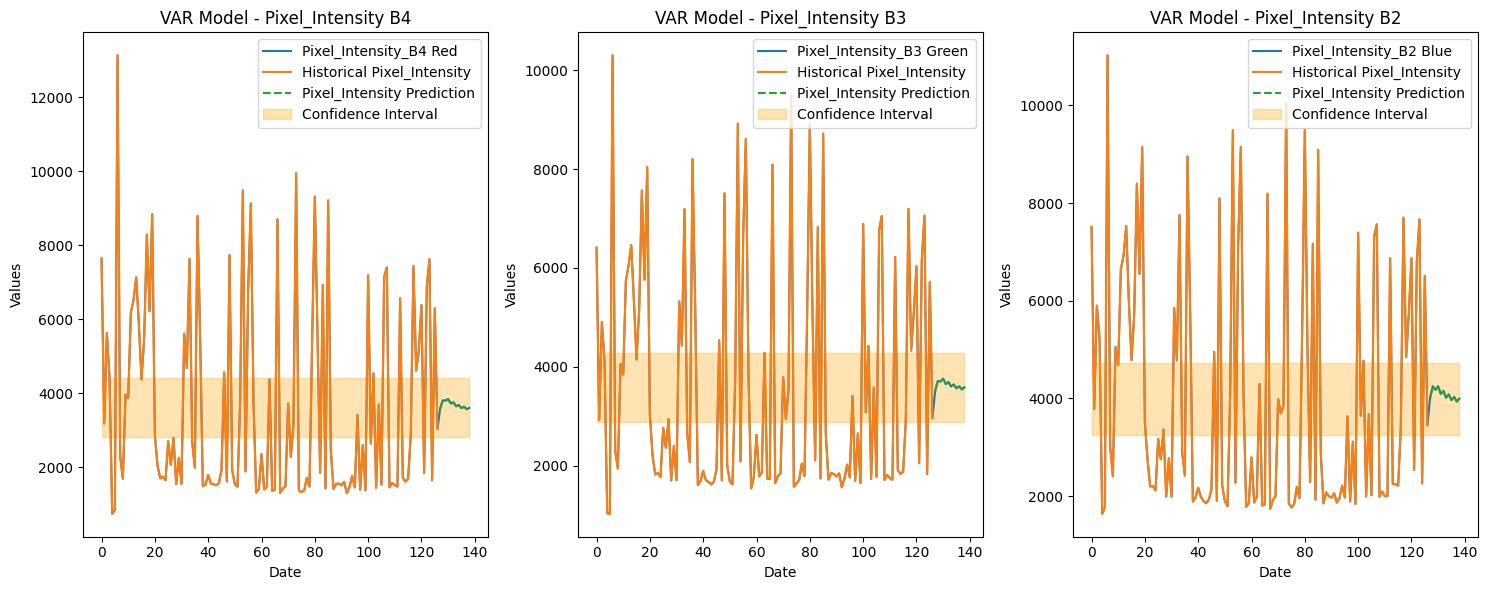

In [104]:
"""
forecast_ci[1:2, :, column_number].flatten(), forecast_ci[2:, :, column_number].flatten() --> alternative confidence interval
concatenated_df['Pixel_Intensity_B4'].iloc[-len(forecast):].index
"""
forecast_df = pd.DataFrame(forecast, columns=concat.columns)
concatenated_df = pd.concat([concat, forecast_df], ignore_index=True)

plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.plot(concatenated_df['Pixel_Intensity_B4'], label='Pixel_Intensity_B4 Red')
plt.plot(concatenated_df['Pixel_Intensity_B4'].iloc[:-len(forecast)], label='Historical Pixel_Intensity')
plt.plot(concatenated_df['Pixel_Intensity_B4'].iloc[-len(forecast):], label='Pixel_Intensity Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Pixel_Intensity_B4'].index, low_conf[0], high_conf[0], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Pixel_Intensity B4')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(132)
plt.plot(concatenated_df['Pixel_Intensity_B3'], label='Pixel_Intensity_B3 Green')
plt.plot(concatenated_df['Pixel_Intensity_B3'].iloc[:-len(forecast)], label='Historical Pixel_Intensity')
plt.plot(concatenated_df['Pixel_Intensity_B3'].iloc[-len(forecast):], label='Pixel_Intensity Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Pixel_Intensity_B3'].index, low_conf[1], high_conf[1], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Pixel_Intensity B3')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(133)
plt.plot(concatenated_df['Pixel_Intensity_B2'], label='Pixel_Intensity_B2 Blue')
plt.plot(concatenated_df['Pixel_Intensity_B2'].iloc[:-len(forecast)], label='Historical Pixel_Intensity')
plt.plot(concatenated_df['Pixel_Intensity_B2'].iloc[-len(forecast):], label='Pixel_Intensity Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Pixel_Intensity_B2'].index, low_conf[2], high_conf[2], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Pixel_Intensity B2')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

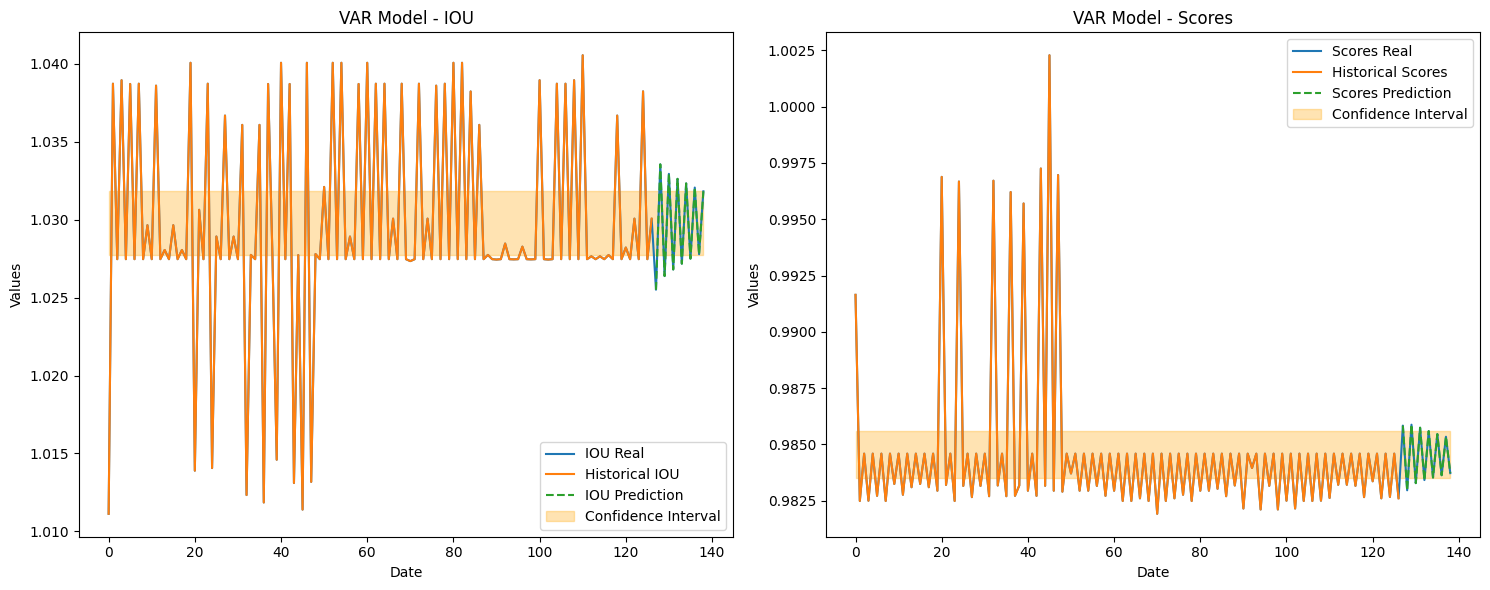

In [105]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(concatenated_df['IOU'], label='IOU Real')
plt.plot(concatenated_df['IOU'].iloc[:-len(forecast)], label='Historical IOU')
plt.plot(concatenated_df['IOU'].iloc[-len(forecast):], label='IOU Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['IOU'].index, low_conf[3], high_conf[3], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - IOU')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(122)
plt.plot(concatenated_df['Scores'], label='Scores Real')
plt.plot(concatenated_df['Scores'].iloc[:-len(forecast)], label='Historical Scores')
plt.plot(concatenated_df['Scores'].iloc[-len(forecast):], label='Scores Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Scores'].index, low_conf[4], high_conf[4], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Scores')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

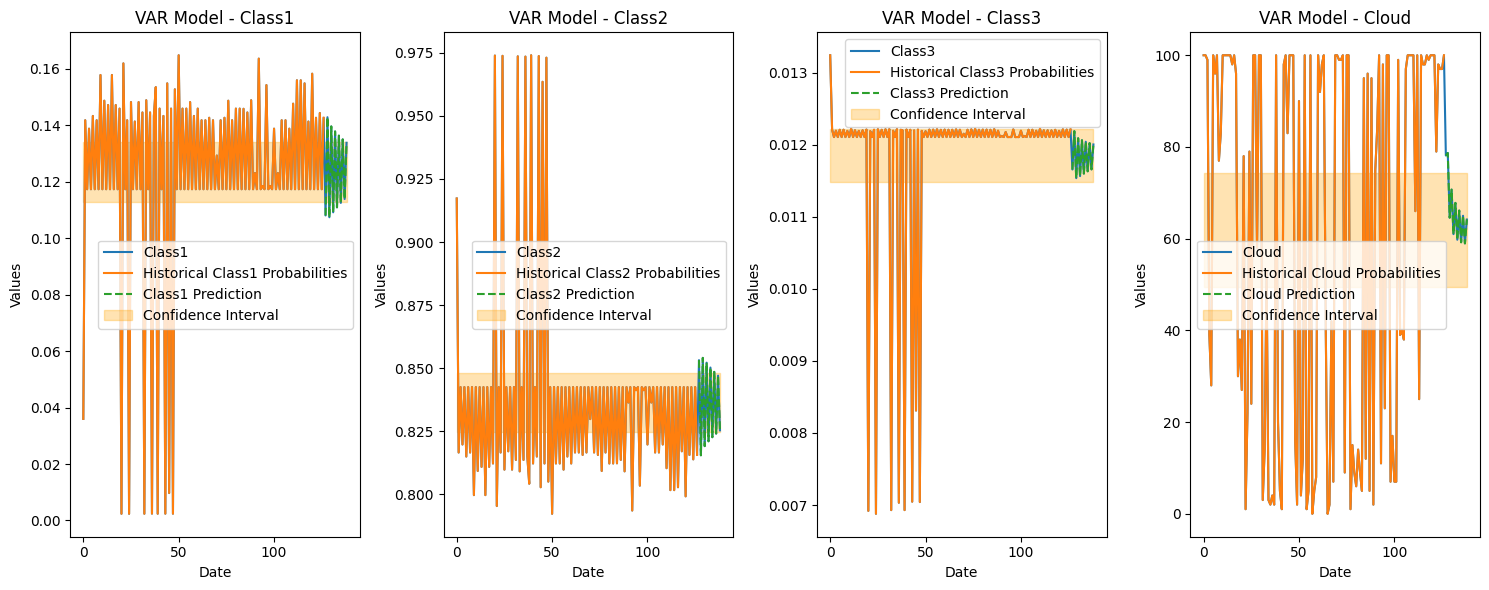

In [106]:
plt.figure(figsize=(15, 6))

plt.subplot(141)
plt.plot(concatenated_df['Class1'], label='Class1')
plt.plot(concatenated_df['Class1'].iloc[:-len(forecast)], label='Historical Class1 Probabilities')
plt.plot(concatenated_df['Class1'].iloc[-len(forecast):], label='Class1 Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Class1'].index, low_conf[5], high_conf[5], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Class1')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(142)
plt.plot(concatenated_df['Class2'], label='Class2')
plt.plot(concatenated_df['Class2'].iloc[:-len(forecast)], label='Historical Class2 Probabilities')
plt.plot(concatenated_df['Class2'].iloc[-len(forecast):], label='Class2 Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Class2'].index, low_conf[6], high_conf[6], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Class2')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(143)
plt.plot(concatenated_df['Class3'], label='Class3')
plt.plot(concatenated_df['Class3'].iloc[:-len(forecast)], label='Historical Class3 Probabilities')
plt.plot(concatenated_df['Class3'].iloc[-len(forecast):], label='Class3 Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Class3'].index, low_conf[7], high_conf[7], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Class3')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(144)
plt.plot(concatenated_df['Cloud_Prob'], label='Cloud')
plt.plot(concatenated_df['Cloud_Prob'].iloc[:-len(forecast)], label='Historical Cloud Probabilities')
plt.plot(concatenated_df['Cloud_Prob'].iloc[-len(forecast):], label='Cloud Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Cloud_Prob'].index, low_conf[11], high_conf[11], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Cloud')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

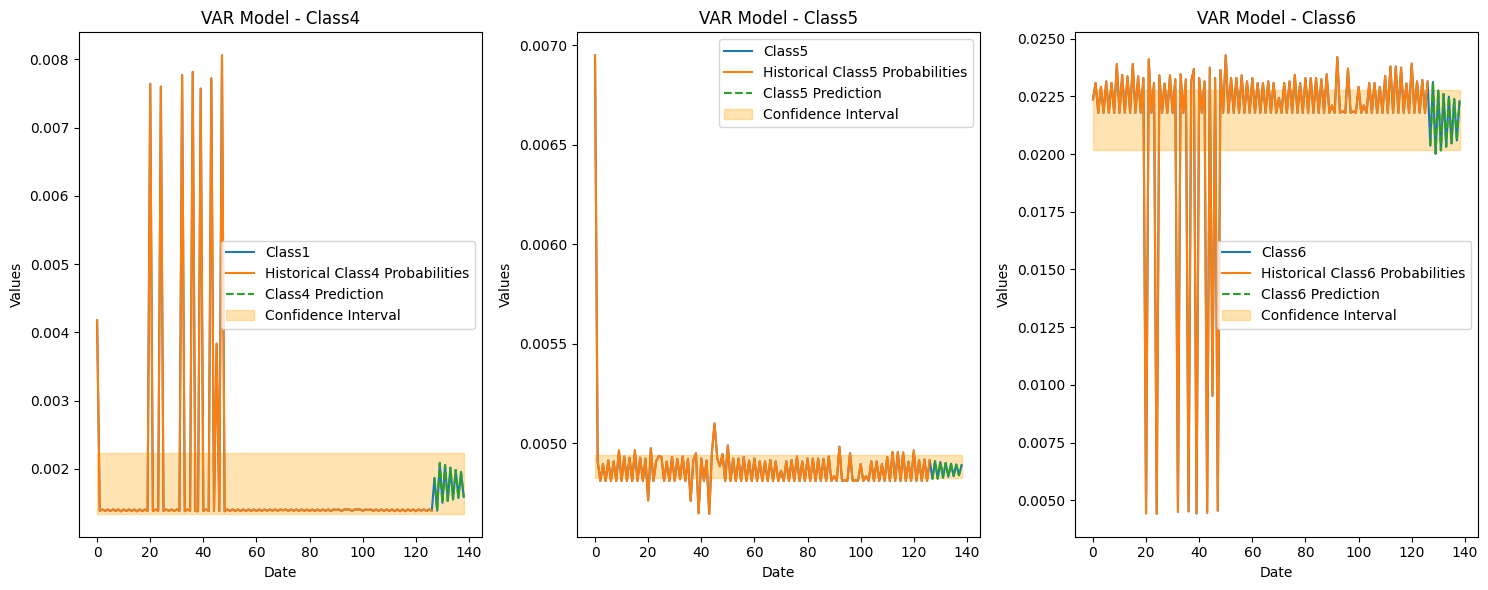

In [107]:
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.plot(concatenated_df['Class4'], label='Class1')
plt.plot(concatenated_df['Class4'].iloc[:-len(forecast)], label='Historical Class4 Probabilities')
plt.plot(concatenated_df['Class4'].iloc[-len(forecast):], label='Class4 Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Class4'].index, low_conf[8], high_conf[8], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Class4')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(132)
plt.plot(concatenated_df['Class5'], label='Class5')
plt.plot(concatenated_df['Class5'].iloc[:-len(forecast)], label='Historical Class5 Probabilities')
plt.plot(concatenated_df['Class5'].iloc[-len(forecast):], label='Class5 Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Class5'].index, low_conf[9], high_conf[9], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Class5')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(133)
plt.plot(concatenated_df['Class6'], label='Class6')
plt.plot(concatenated_df['Class6'].iloc[:-len(forecast)], label='Historical Class6 Probabilities')
plt.plot(concatenated_df['Class6'].iloc[-len(forecast):], label='Class6 Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Class6'].index, low_conf[10], high_conf[10], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Class6')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()